In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_1.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_256.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_221.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_93.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_198.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_137.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_120.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_13.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_40.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_217.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_3.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
/kaggle/input/feature-selelcted-dataset/t

In [2]:
!pip install lime shap -q

In [3]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,  Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import json
from tensorflow.keras.applications.vgg16 import preprocess_input
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input

2025-05-01 10:23:15.919165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746094996.134245      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746094996.194631      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

In [5]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [6]:
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [7]:
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [9]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [10]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels= tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [11]:
class_dict_c = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

#  Model to Classify Normal, Covid19, Pneumonia

In [12]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output

x = Flatten()(x)

x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  #changed this not like the paper bec i have only 3 classes

# Create the final model
model_c = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_c.compile(optimizer=Adam(learning_rate=0.001), #learning rate 0.001 like the paper
               loss='categorical_crossentropy', #sparse_categorical_crossentropy like the paper
              metrics=['accuracy'])

# Print model summary
model_c.summary()

I0000 00:00:1746095027.122310      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746095027.123075      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 119,558,147 (456.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_c = model_c.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10


I0000 00:00:1746095035.841753      71 service.cc:148] XLA service 0x7c17f8010140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746095035.842558      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746095035.842583      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746095036.210405      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 10:09 16s/step - accuracy: 0.4375 - loss: 1.4579

I0000 00:00:1746095049.196786      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 723ms/step - accuracy: 0.5407 - loss: 9.4233 - val_accuracy: 0.7980 - val_loss: 0.4903
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.7387 - loss: 0.5629 - val_accuracy: 0.7616 - val_loss: 0.4682
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.7598 - loss: 0.5243 - val_accuracy: 0.8609 - val_loss: 0.3721
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.8550 - loss: 0.3672 - val_accuracy: 0.8775 - val_loss: 0.3214
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.8684 - loss: 0.3434 - val_accuracy: 0.8609 - val_loss: 0.3262
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.8657 - loss: 0.3280 - val_accuracy: 0.8940 - val_loss: 0.3213
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.8733 - loss: 0.2911 - val_accuracy: 0.8477 - val_loss: 0.3397
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.8639 - loss: 0.3188 - val_accuracy: 0.8742 

# Training and Validation Loss

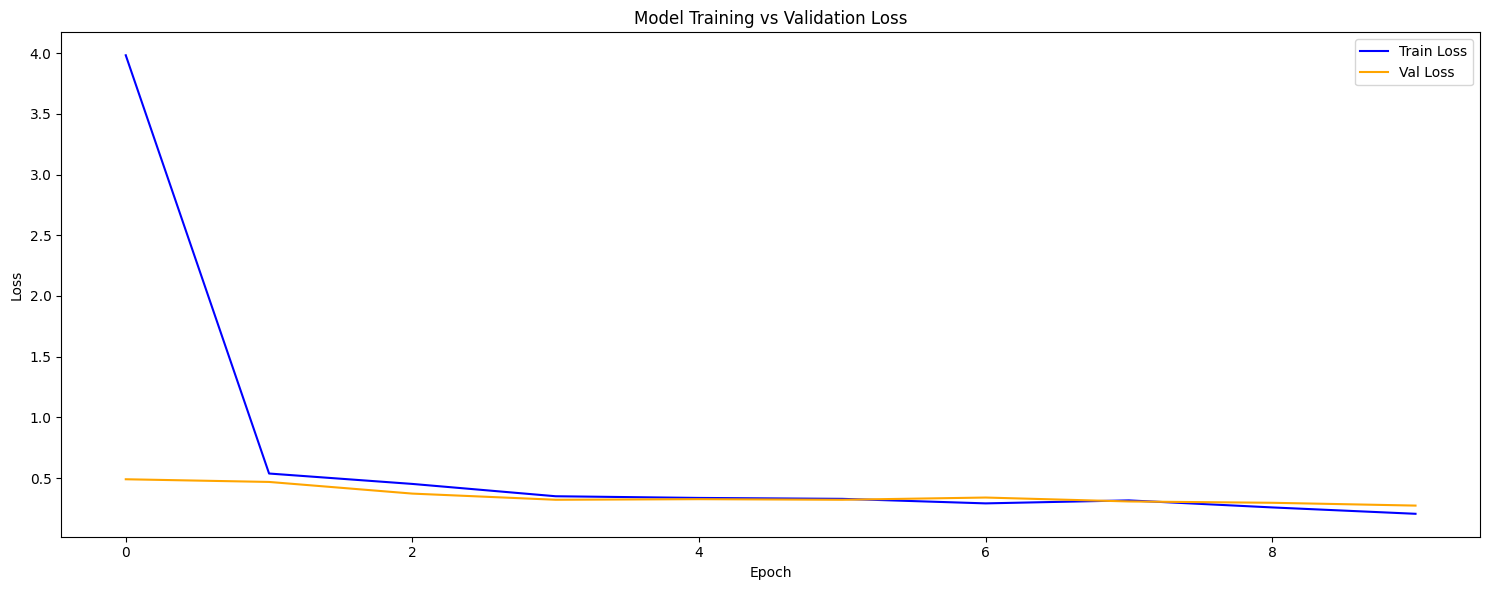

In [14]:
plt.figure(figsize=(15, 6))

plt.plot(history_c.history['loss'], label='Train Loss', color='blue')
plt.plot(history_c.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Training and Validation Accuracy

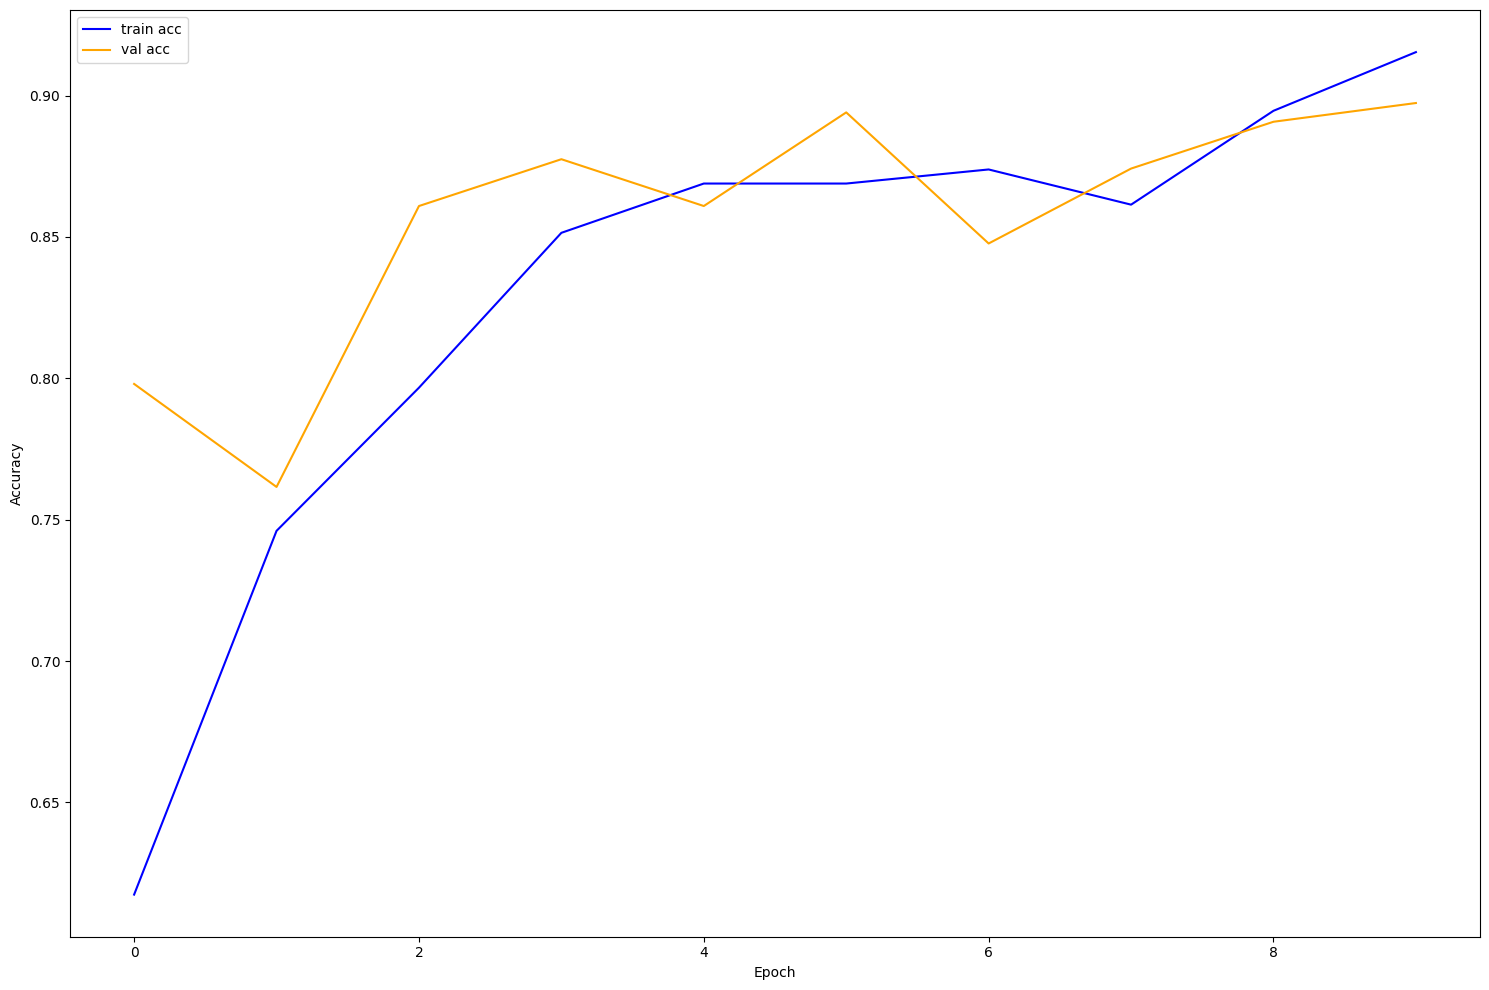

In [15]:
plt.figure(figsize=(15, 10))

plt.plot(history_c.history['accuracy'], label='train acc', color='blue')
plt.plot(history_c.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#  Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step


Text(0.5, 1.0, 'Confusion Matrix')

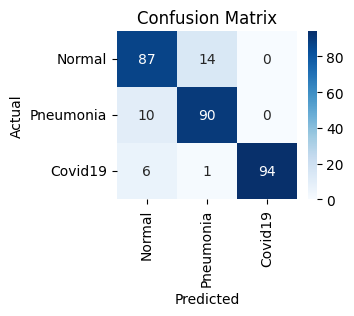

In [16]:
y_pred = model_c.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [17]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9757973334646897


# GRAD CAM

In [18]:
def gradCam(image, true_label, layer_conv_name, model, which):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    loss = None
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        if which == "Categorical":
          loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
        else:
          loss = tf.losses.binary_crossentropy(true_label, predictions)
        
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [19]:
def getHeatMap(images, labels, model, which):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                                 'block5_conv3', model, which) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions

In [20]:
class_dict_c = {0:'covid19',
              1:'normal',
              2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# GRADCAM with model for classifying Normal or Covid19 or Pneumonia

In [21]:
heatmaps, pred = getHeatMap(test_images, test_labels, model_c, "Categorical")
print(heatmaps.shape)

(128, 224, 224)


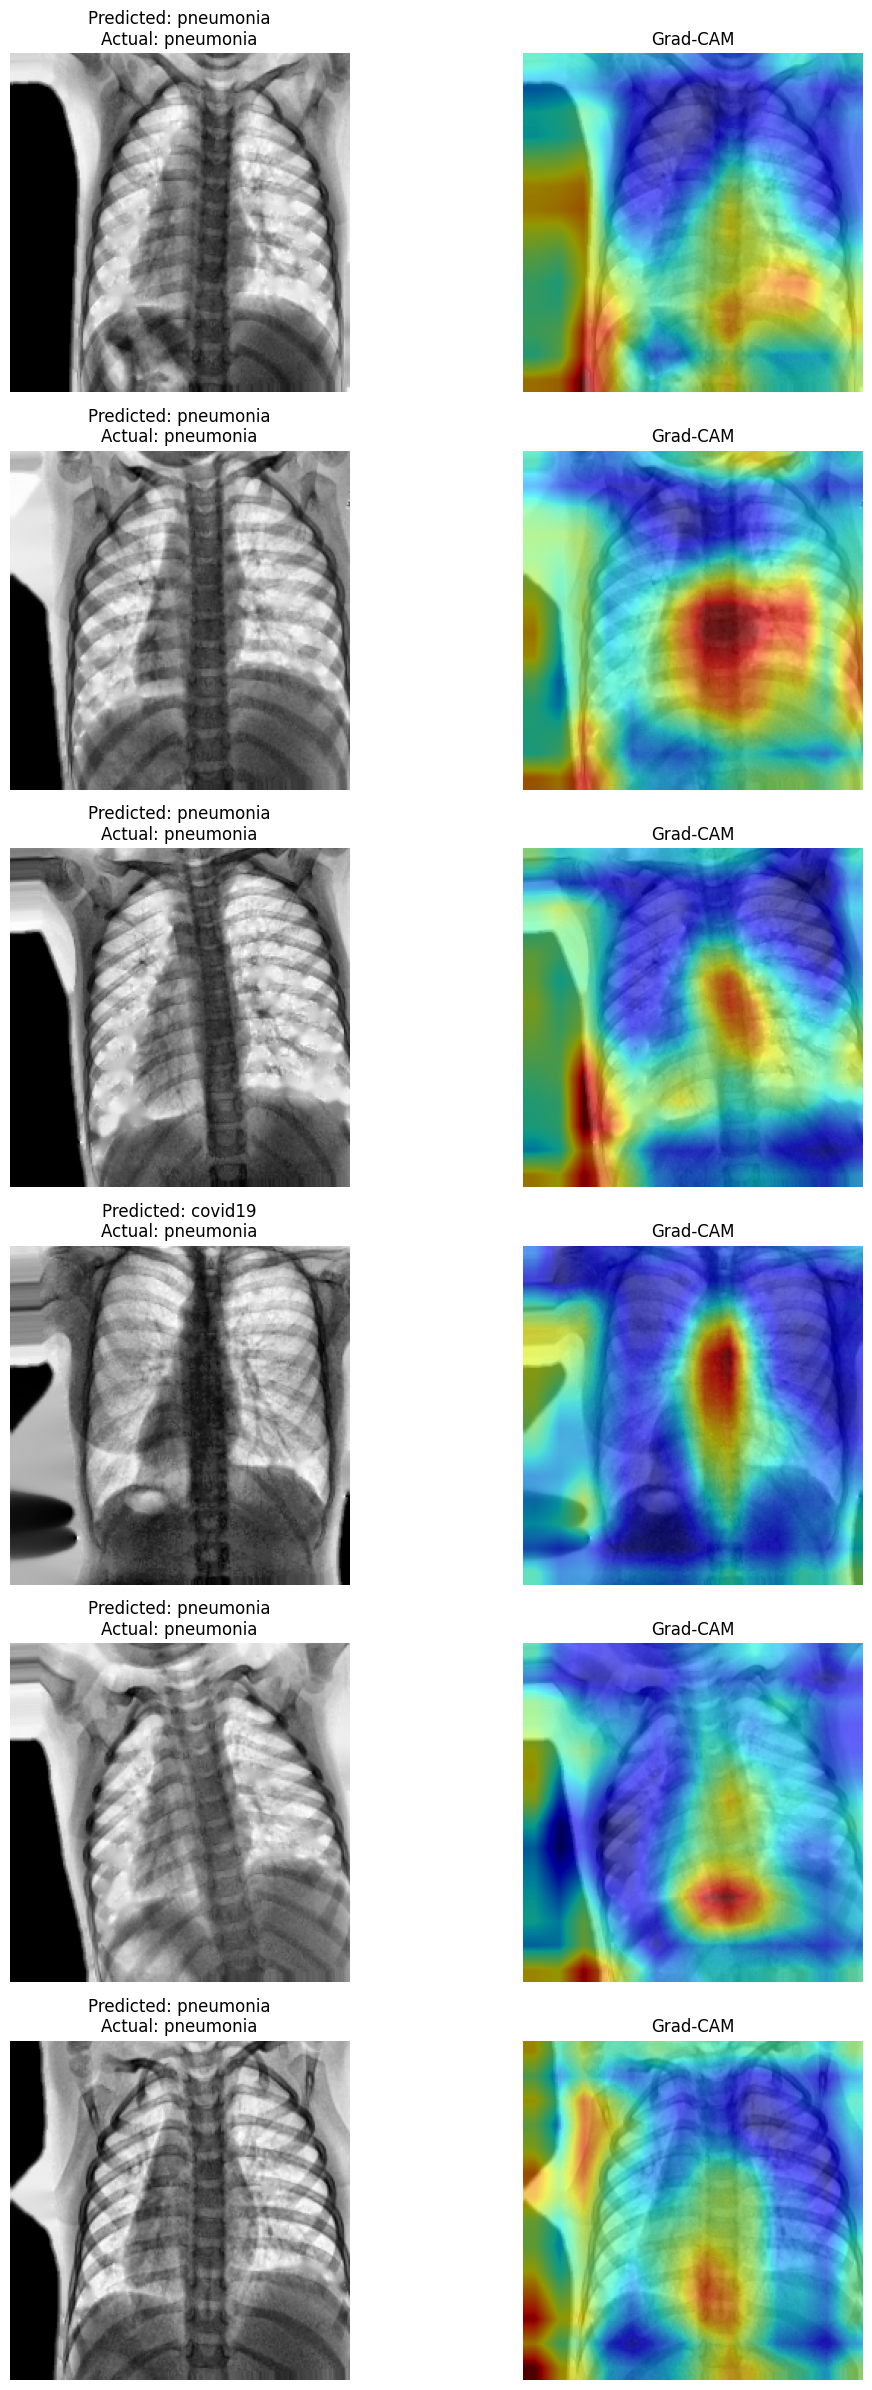

In [22]:
draw(test_images[:6], heatmaps[:6], test_labels[:6], pred)

# Explainability with Lime

# LIME with model for classifying Normal or Covid19 or Pneumonia

In [23]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries

In [24]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (224, 224), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

In [25]:
def predict_fn(images):
    images = np.array(images)
    if images.shape[-1] != 3:
        images = np.repeat(images, 3, axis=-1)
    images = np.clip(images, 0, 1)
    return model_c.predict(images, verbose=0)

In [26]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

  0%|          | 0/500 [00:00<?, ?it/s]

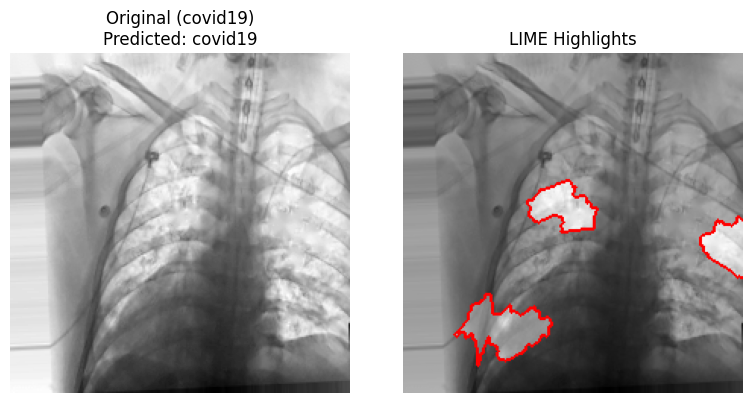

Image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_253.png
Predicted probabilities: {'covid19': 0.9567674, 'normal': 0.037212107, 'pneumonia': 0.0060205404}



  0%|          | 0/500 [00:00<?, ?it/s]

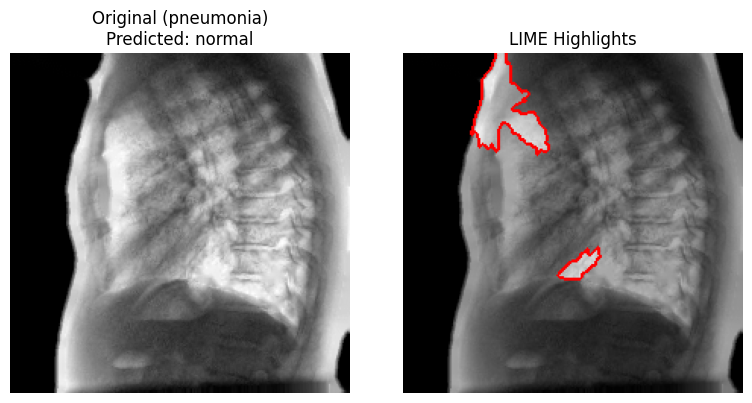

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
Predicted probabilities: {'covid19': 0.0011545209, 'normal': 0.99883455, 'pneumonia': 1.1000803e-05}



  0%|          | 0/500 [00:00<?, ?it/s]

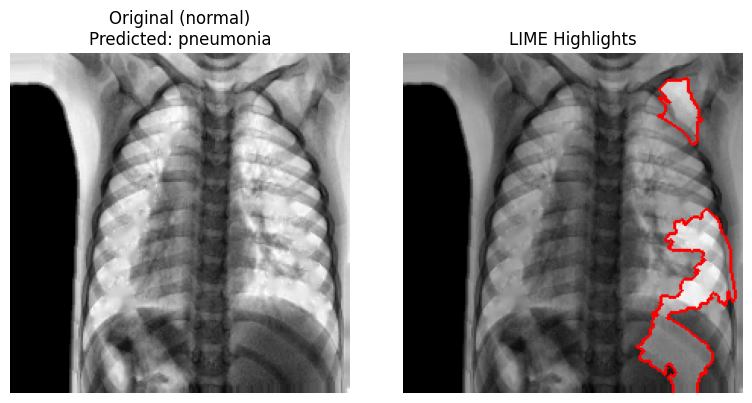

Image: /kaggle/input/feature-selelcted-dataset/test/normal/image_301.png
Predicted probabilities: {'covid19': 6.688019e-12, 'normal': 7.8693774e-11, 'pneumonia': 1.0}



In [27]:
class_labels = ['covid19', 'normal', 'pneumonia']
test_dir = '/kaggle/input/feature-selelcted-dataset/test'
try:
    image_paths = [
        (os.path.join(test_dir, 'covid19', os.listdir(os.path.join(test_dir, 'covid19'))[0]), 'covid19'),
        (os.path.join(test_dir, 'pneumonia', os.listdir(os.path.join(test_dir, 'pneumonia'))[0]), 'pneumonia'),
        (os.path.join(test_dir, 'normal', os.listdir(os.path.join(test_dir, 'normal'))[0]), 'normal')
    ]
    explain_with_lime(model_c, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

# DeepLift

# LIME with model for classifying Normal or Patient

In [28]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [29]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [30]:
# Select 3 samples per class
num_classes = 3
samples_per_class = 3
class_indices = np.argmax(test_labels, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

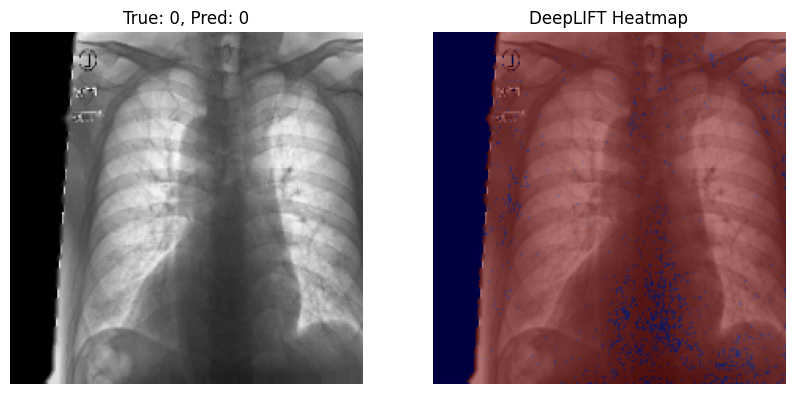

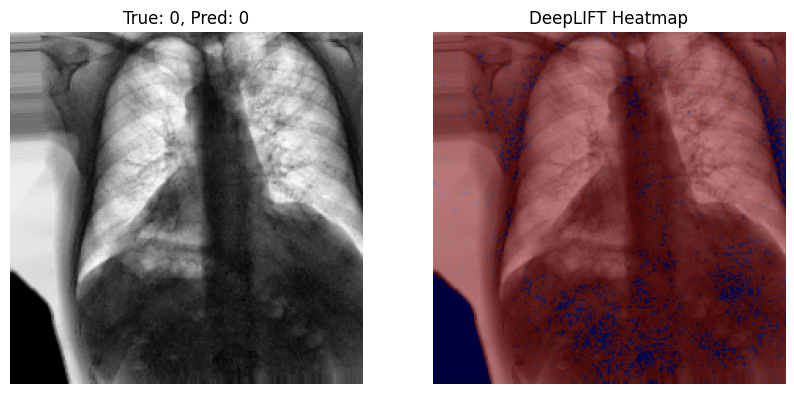

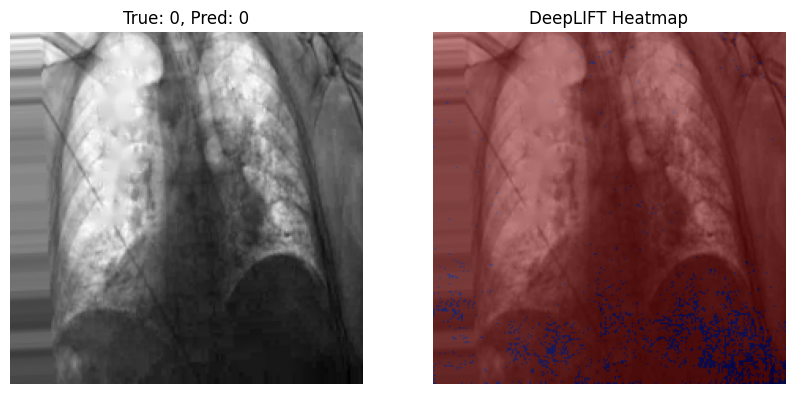

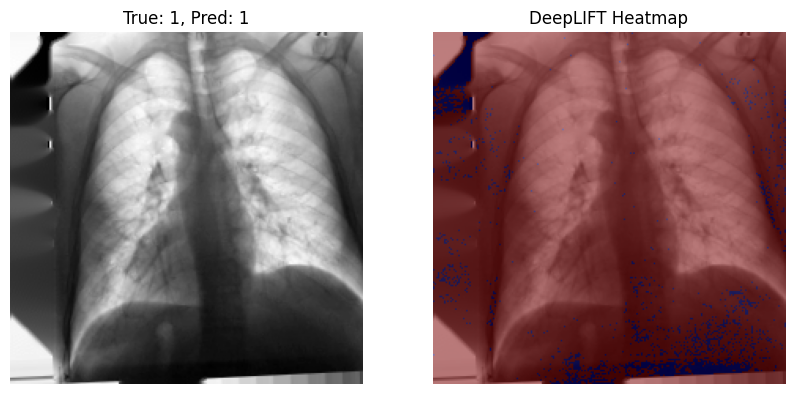

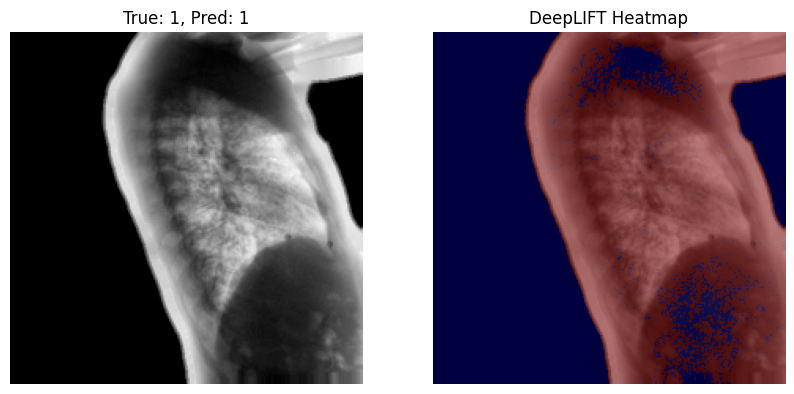

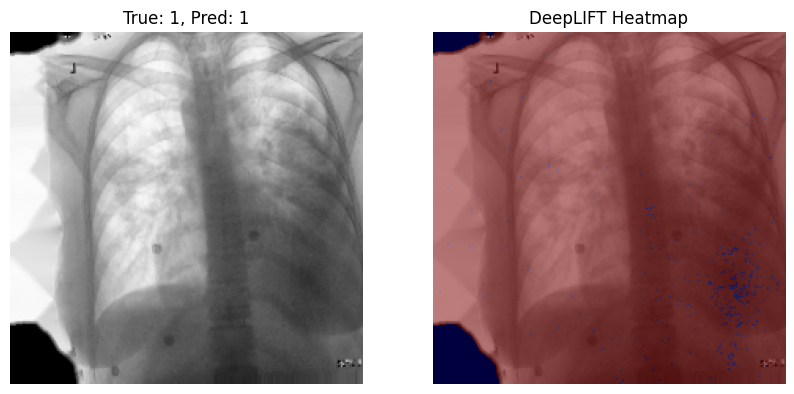

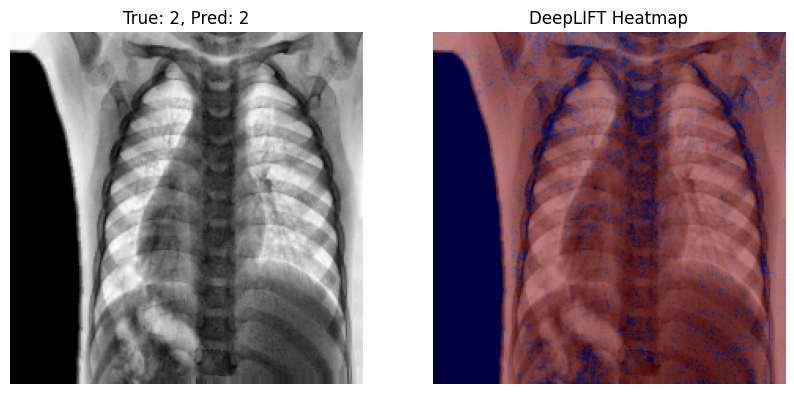

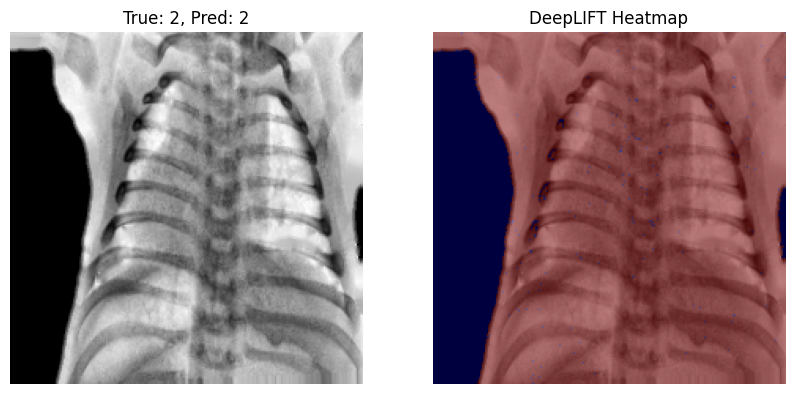

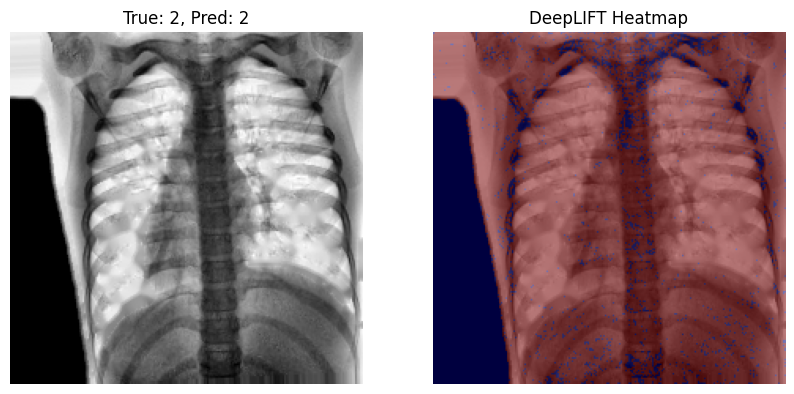

In [31]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model_c, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

# Permutation Importance

In [32]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']

class_indices = {}
for i in range(len(test_labels)):
    true_label = np.argmax(test_labels[i])
    if true_label not in class_indices:
        class_indices[true_label] = i
    if len(class_indices) == 3:
        break

# Permutation Importance for model 

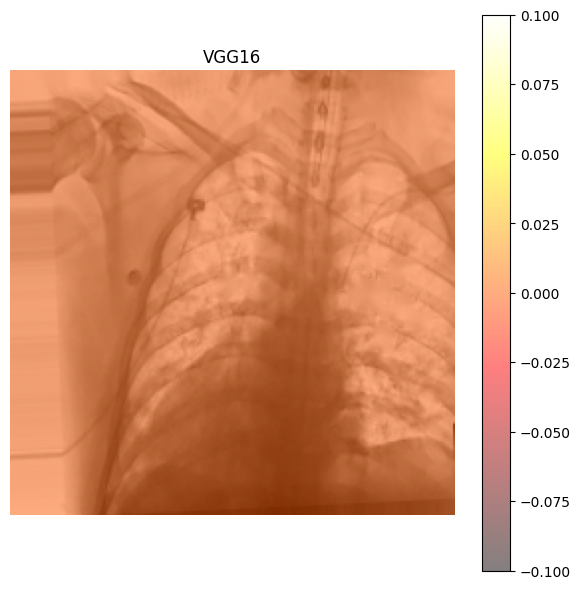

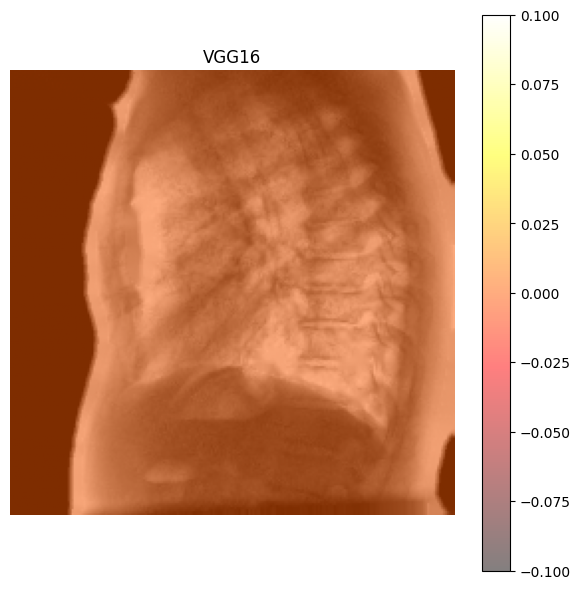

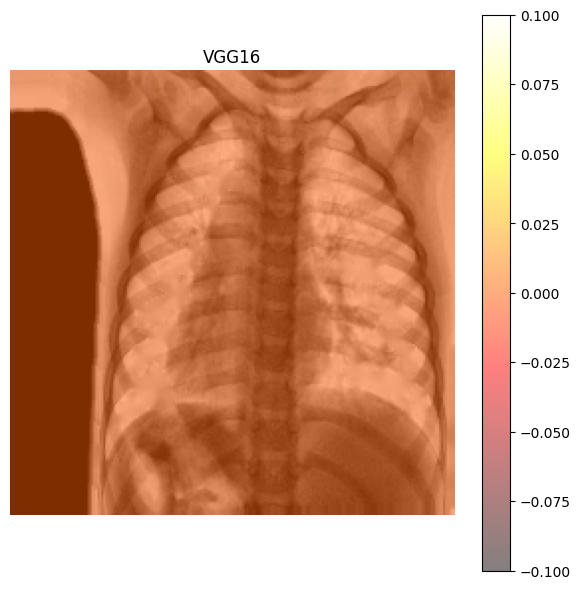

In [33]:
img_covid = test_images[class_indices[0]]
img_pneumnia = test_images[class_indices[1]]
img_normal = test_images[class_indices[2]]

def permutation_importance(image, model, class_index, model_name, raw_image):
    image = np.expand_dims(image, axis=0)
    correct_one_prediction = model.predict(image, verbose=0)
    correct_one_class = np.argmax(correct_one_prediction)
    correct_one = int(correct_one_class == class_index)

    importance_map = np.zeros((224, 224, 3))
    
    for i in range(0, 224, 24):
        for j in range(0, 224, 24):
            for c in range(3):
                permuted = image.copy()
                permuted[0, i, j, c] = np.random.rand()
                pred = model.predict(permuted, verbose=0)
                pred_class = np.argmax(pred)
                correct = int(pred_class == class_index)
                importance_map[i, j, c] = correct_one - correct

    heatmap = np.mean(importance_map, axis=-1)

    plt.figure(figsize=(6, 6))
    plt.imshow(raw_image, cmap='gray')
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

permutation_importance(img_covid, model_c, class_index=0, model_name="VGG16", raw_image=img_covid)
permutation_importance(img_pneumnia, model_c, class_index=1, model_name="VGG16", raw_image=img_pneumnia)
permutation_importance(img_normal, model_c, class_index=2, model_name="VGG16", raw_image=img_normal)

# Benchmarking

# Xception

In [34]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # 3-class output

model_x = Model(inputs=base_model.input, outputs=x)

model_x.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_x.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 23,485,995 (89.59 MB)

 Trainable params: 2,624,515 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [35]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_x = model_x.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 628ms/step - accuracy: 0.6153 - loss: 0.8976 - val_accuracy: 0.7748 - val_loss: 0.5235
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.7318 - loss: 0.6096 - val_accuracy: 0.7980 - val_loss: 0.4847
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.7581 - loss: 0.5007 - val_accuracy: 0.7483 - val_loss: 0.5052
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.7933 - loss: 0.4470 - val_accuracy: 0.7815 - val_loss: 0.4577
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.8241 - loss: 0.3868 - val_accuracy: 0.7517 - val_loss: 0.4885
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8067 - loss: 0.4399 - val_accuracy: 0.7914 - val_loss: 0.4588
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.8214 - loss: 0.3917 - val_accuracy: 0.8212 - val_loss: 0.4006
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.8317 - loss: 0.3742 - val_accuracy: 0

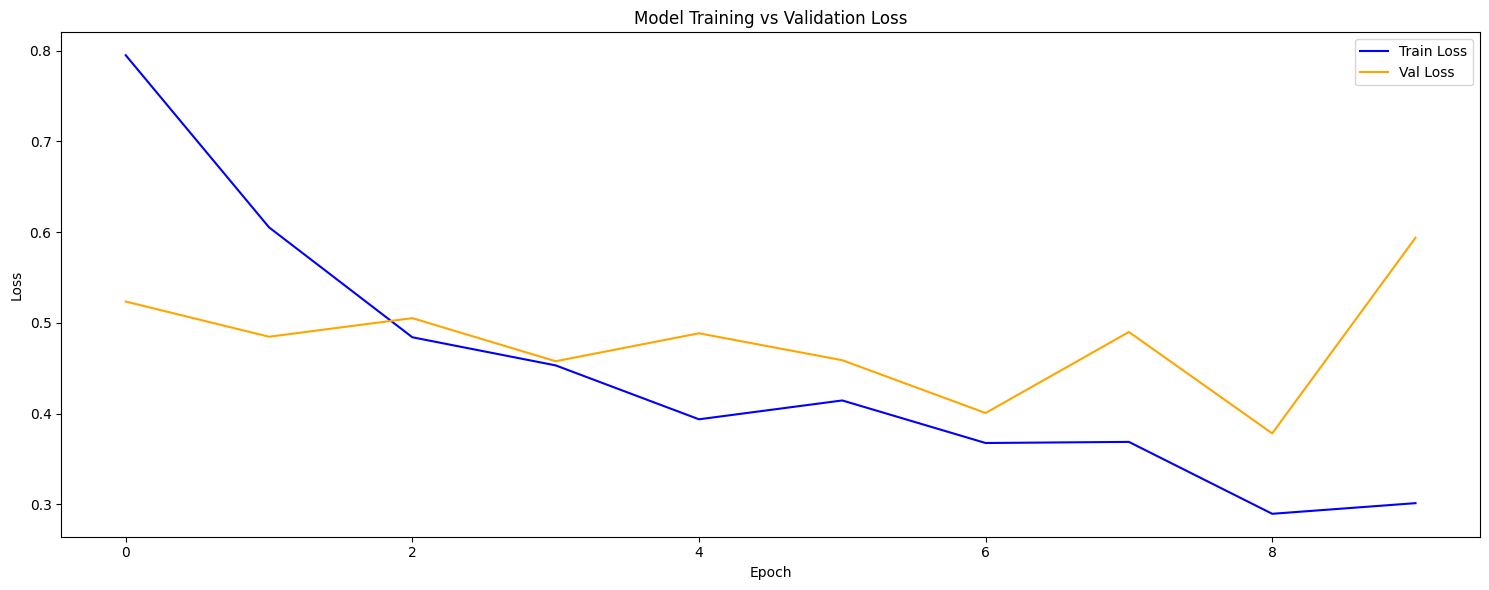

In [36]:
plt.figure(figsize=(15, 6))

plt.plot(history_x.history['loss'], label='Train Loss', color='blue')
plt.plot(history_x.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


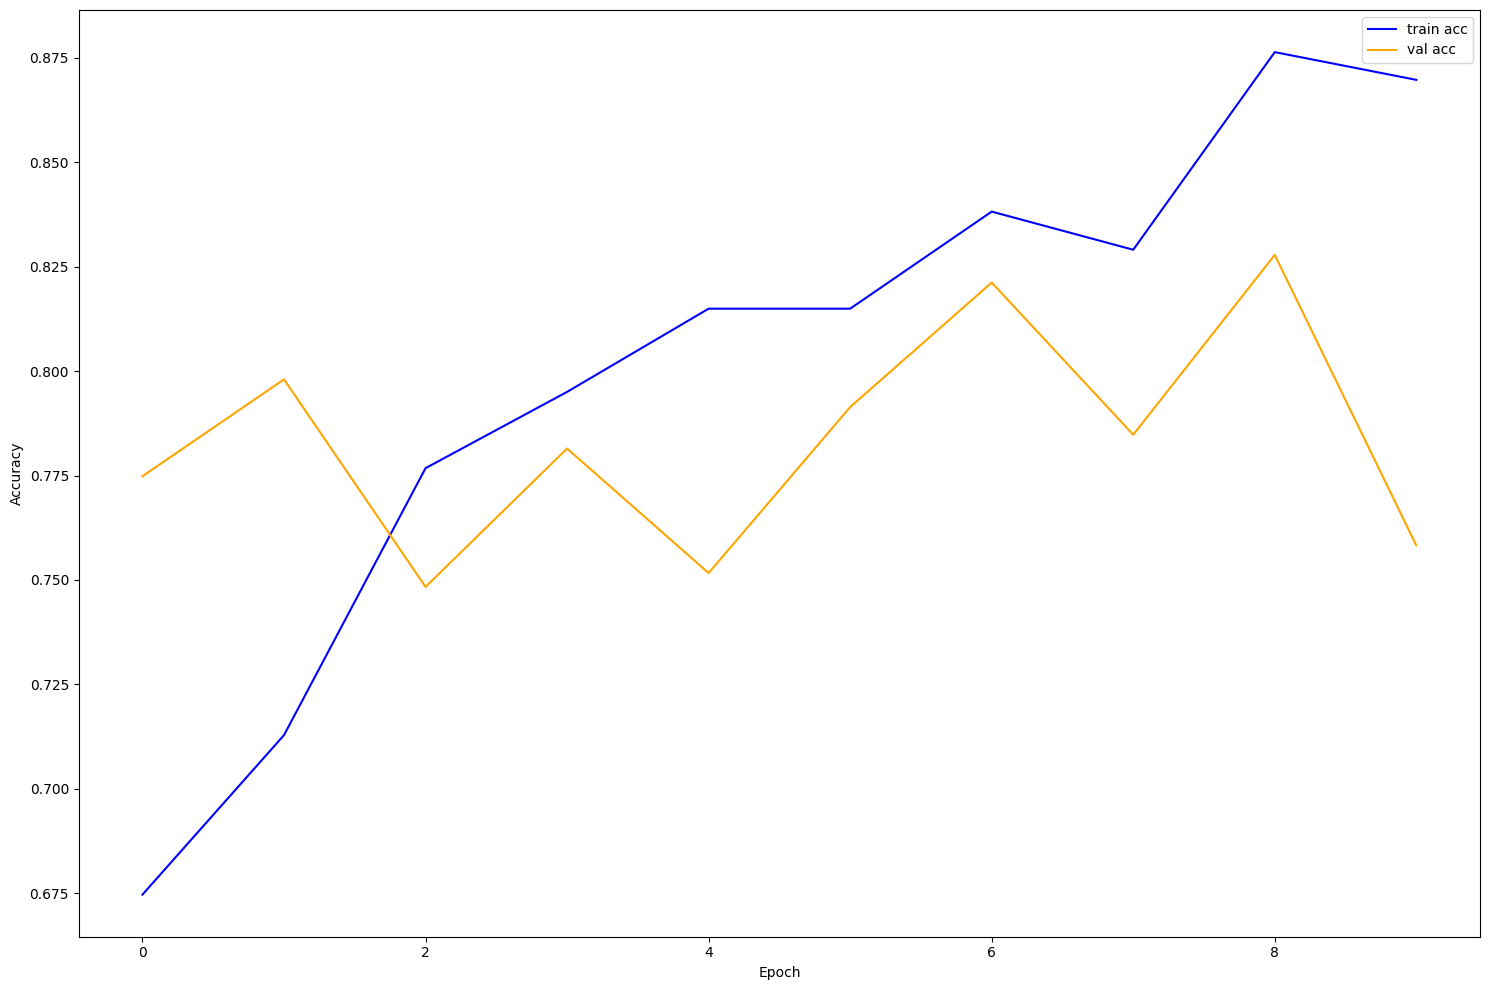

In [37]:
plt.figure(figsize=(15, 10))

plt.plot(history_x.history['accuracy'], label='train acc', color='blue')
plt.plot(history_x.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step


Text(0.5, 1.0, 'Confusion Matrix')

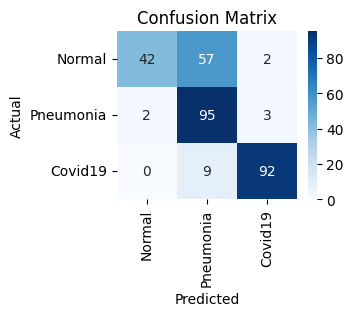

In [38]:
y_pred = model_x.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [39]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9459652233880105


# ResNet50

In [40]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_R = Model(inputs=base_model.input, outputs=x)

model_R.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_R.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 451,427,203 (1.68 GB)

 Trainable params: 427,839,491 (1.59 GB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_R = model_R.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - accuracy: 0.3830 - loss: 41.9759 - val_accuracy: 0.6126 - val_loss: 0.7758
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.5535 - loss: 0.8594 - val_accuracy: 0.6424 - val_loss: 0.7765
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.5982 - loss: 0.7755 - val_accuracy: 0.6589 - val_loss: 0.6812
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.5617 - loss: 0.7864 - val_accuracy: 0.6126 - val_loss: 0.6876
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5493 - loss: 0.8115 - val_accuracy: 0.5993 - val_loss: 0.7540
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.5547 - loss: 0.8346 - val_accuracy: 0.6258 - val_loss: 0.7152
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.4564 - loss: 0.9013 - val_accuracy: 0.6192 - val_loss: 0.7169
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.4689 - loss: 0.9227 - val_accuracy: 

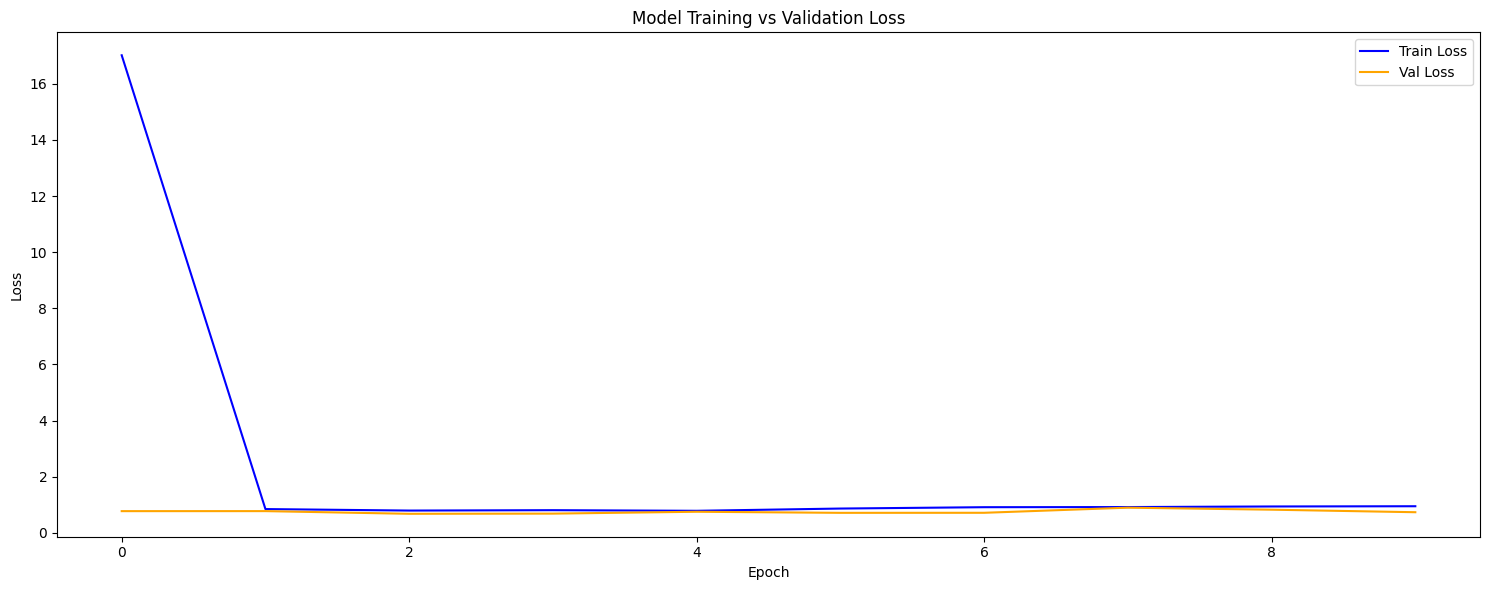

In [42]:
plt.figure(figsize=(15, 6))

plt.plot(history_R.history['loss'], label='Train Loss', color='blue')
plt.plot(history_R.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


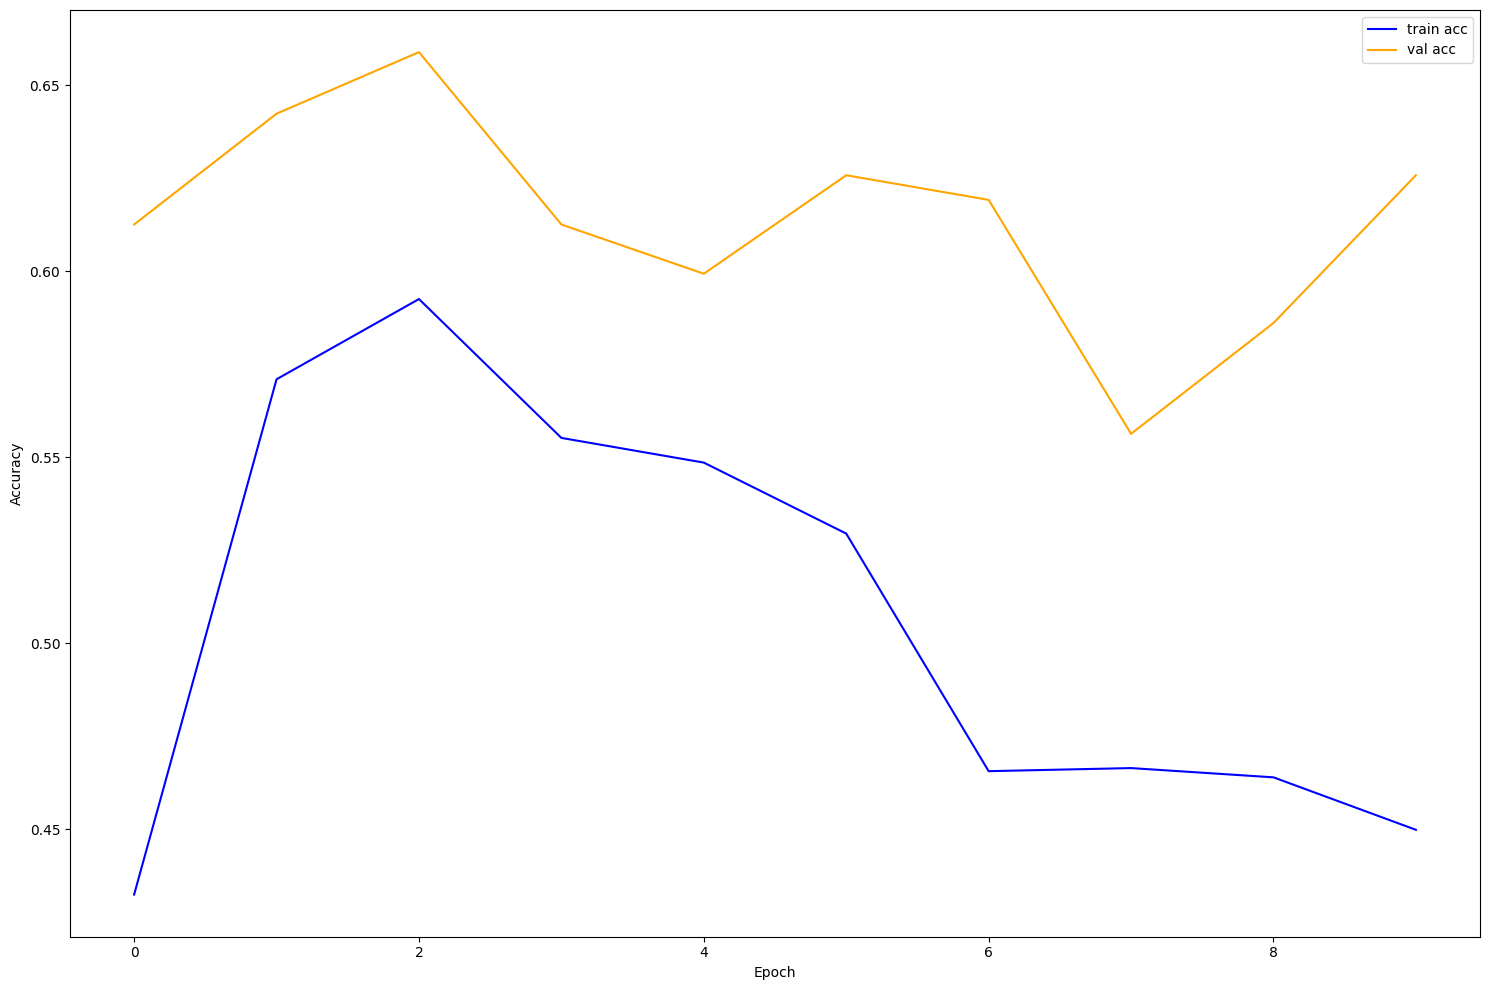

In [43]:
plt.figure(figsize=(15, 10))

plt.plot(history_R.history['accuracy'], label='train acc', color='blue')
plt.plot(history_R.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step


Text(0.5, 1.0, 'Confusion Matrix')

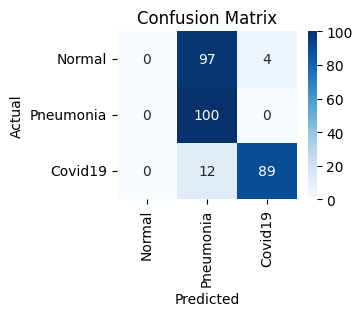

In [44]:
y_pred = model_R.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [45]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.8008598098615831


# XNet

In [46]:
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)

model_xNet = Model(inputs=inputs, outputs=outputs)

model_xNet.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_xNet.summary()


Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,835,587 (365.58 MB)

 Trainable params: 95,835,587 (365.58 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_xNet = model_xNet.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.4345 - loss: 4.0443 - val_accuracy: 0.7285 - val_loss: 0.5925
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7393 - loss: 0.6025 - val_accuracy: 0.8079 - val_loss: 0.5414
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8059 - loss: 0.4254 - val_accuracy: 0.8278 - val_loss: 0.4686
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8938 - loss: 0.2757 - val_accuracy: 0.8510 - val_loss: 0.4388
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9495 - loss: 0.1610 - val_accuracy: 0.8709 - val_loss: 0.4370
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9606 - loss: 0.1269 - val_accuracy: 0.8609 - val_loss: 0.4763
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9771 - loss: 0.0761 - val_accuracy: 0.8874 - val_loss: 0.5786
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9874 - loss: 0.0420 - val_accuracy: 0.8311 -

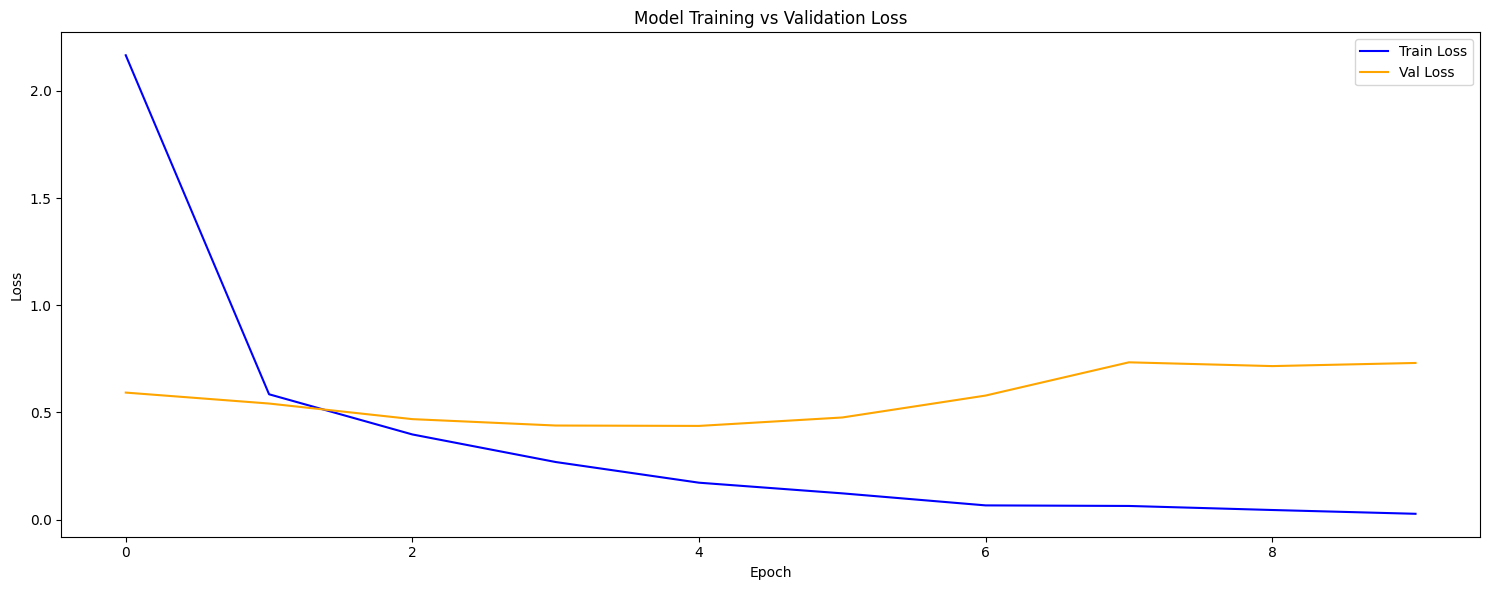

In [48]:
plt.figure(figsize=(15, 6))

plt.plot(history_xNet.history['loss'], label='Train Loss', color='blue')
plt.plot(history_xNet.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


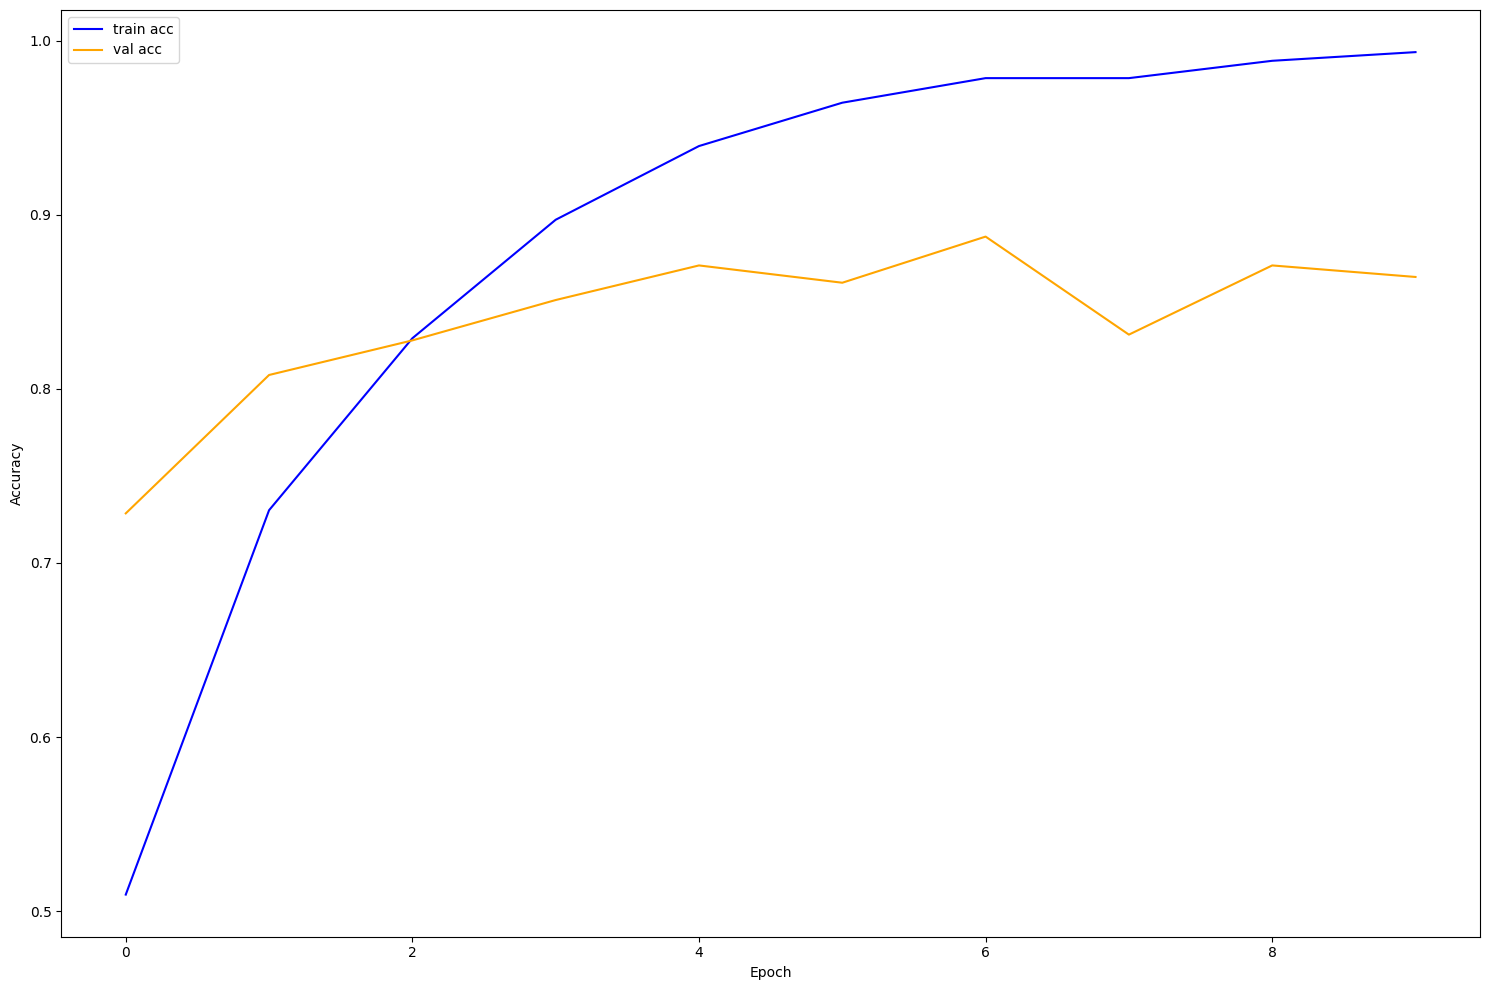

In [49]:
plt.figure(figsize=(15, 10))

plt.plot(history_xNet.history['accuracy'], label='train acc', color='blue')
plt.plot(history_xNet.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Text(0.5, 1.0, 'Confusion Matrix')

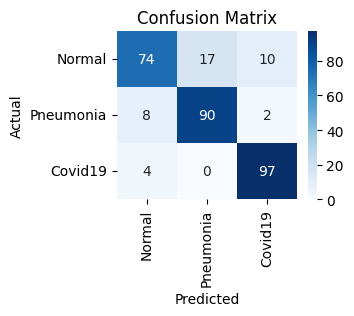

In [50]:
y_pred = model_xNet.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [51]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9607453655813343


# AlexNet

In [52]:
model_A = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_A.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_A.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,759,299 (178.37 MB)

 Trainable params: 46,759,299 (178.37 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_A = model_A.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.3455 - loss: 1.5661 - val_accuracy: 0.3642 - val_loss: 1.0887
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4990 - loss: 1.0136 - val_accuracy: 0.5530 - val_loss: 0.8975
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5970 - loss: 0.8362 - val_accuracy: 0.5629 - val_loss: 0.8304
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6323 - loss: 0.7956 - val_accuracy: 0.6159 - val_loss: 0.7821
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6369 - loss: 0.7291 - val_accuracy: 0.5728 - val_loss: 0.8077
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6311 - loss: 0.7156 - val_accuracy: 0.6192 - val_loss: 0.7646
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6532 - loss: 0.6939 - val_accuracy: 0.6325 - val_loss: 0.7624
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6510 - loss: 0.7231 - val_accuracy: 0.6391 -

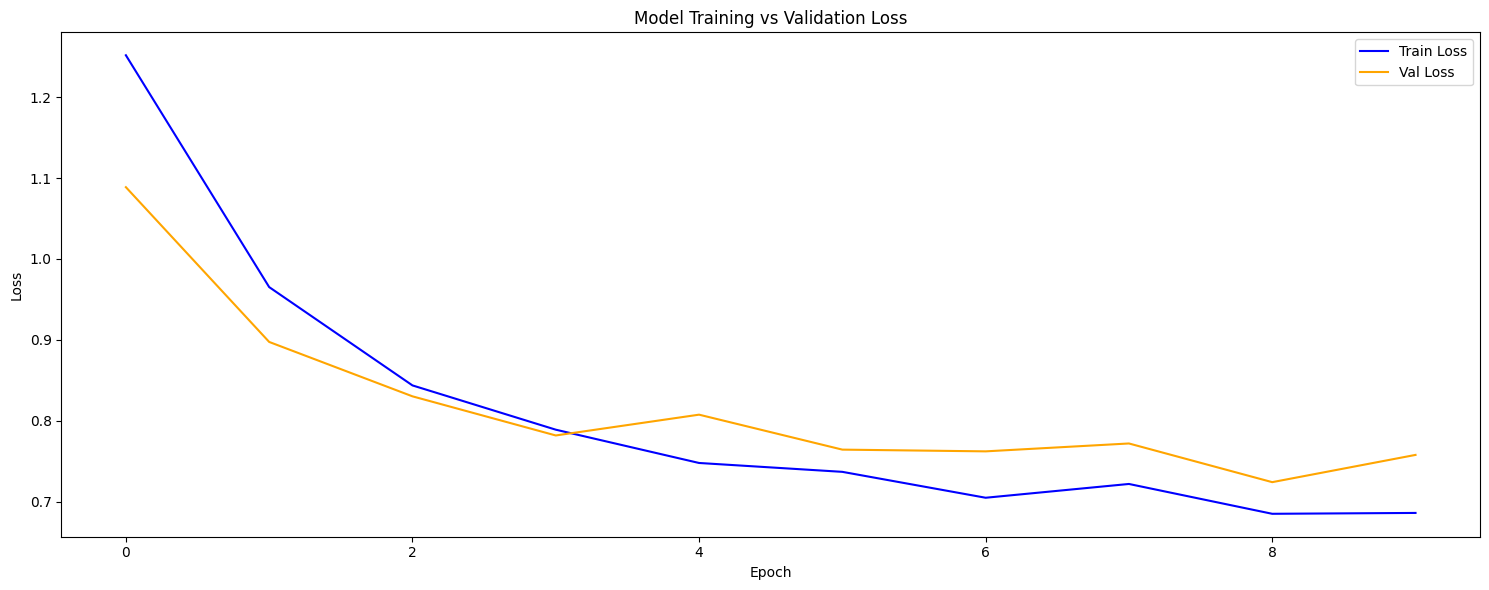

In [54]:
plt.figure(figsize=(15, 6))

plt.plot(history_A.history['loss'], label='Train Loss', color='blue')
plt.plot(history_A.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


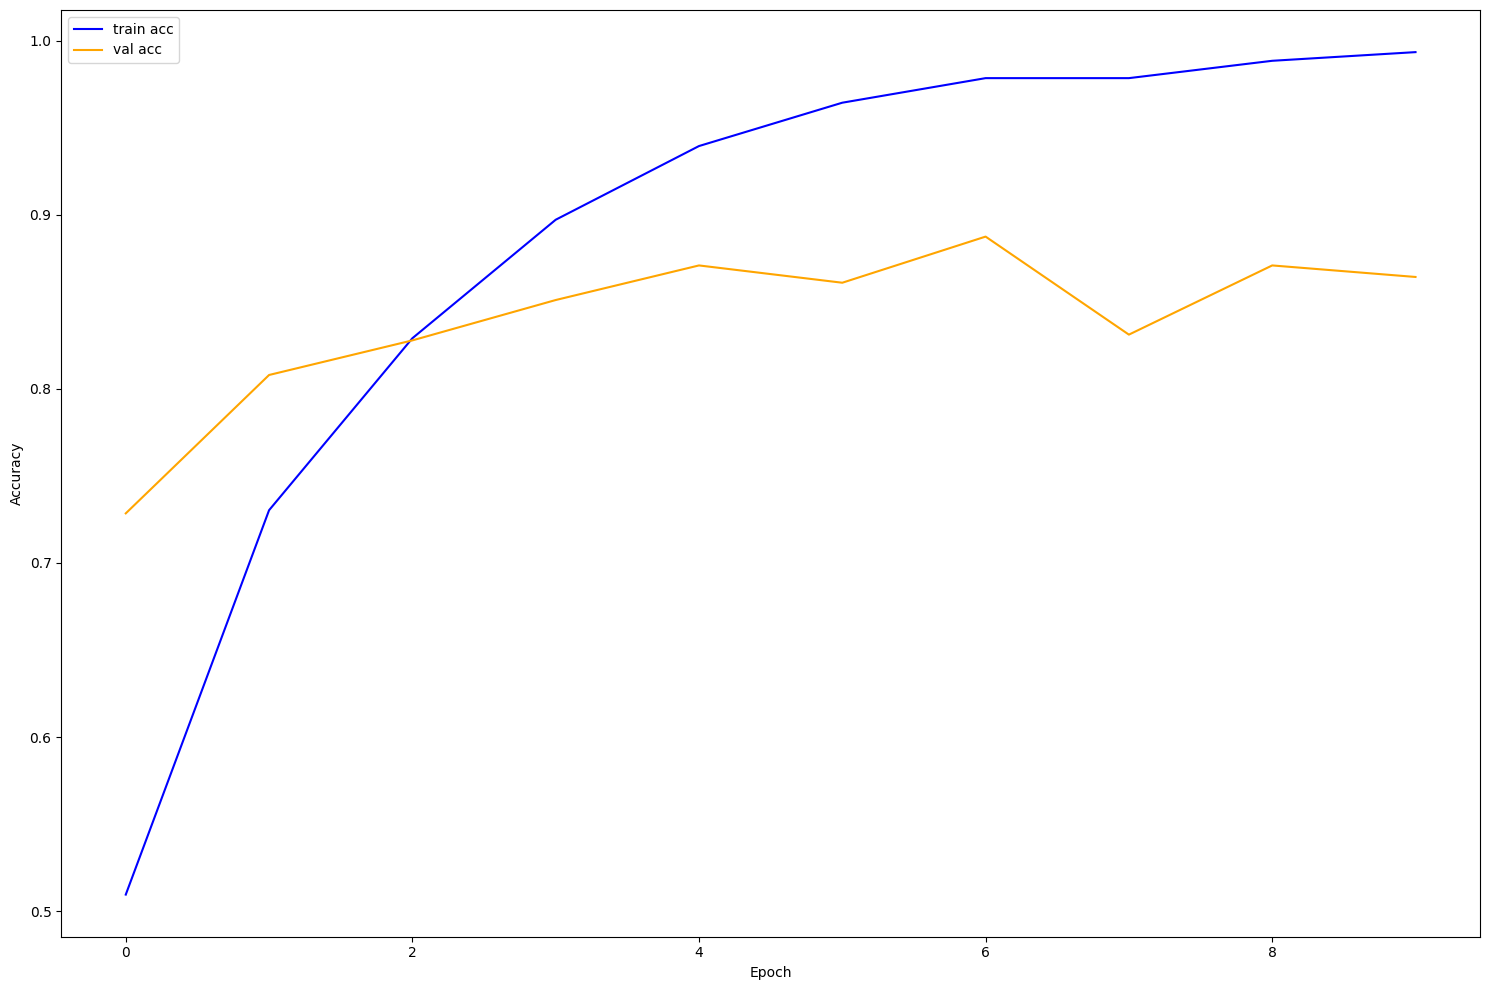

In [55]:
plt.figure(figsize=(15, 10))

plt.plot(history_xNet.history['accuracy'], label='train acc', color='blue')
plt.plot(history_xNet.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


Text(0.5, 1.0, 'Confusion Matrix')

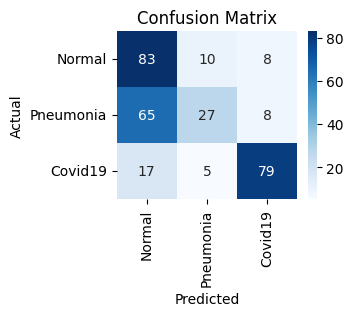

In [56]:
y_pred = model_A.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [57]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.7964236162422212


# Inception V3

In [58]:
# !pip install git+https://github.com/qubvel/classification_models.git@master


In [59]:
# from classification_models.tfkeras import Classifiers
# InceptionV3, _ = Classifiers.get('inceptionv3')
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False

# x = Flatten()(base_model.output)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(3, activation='softmax')(x)

# # Create final model
# model_I = Model(inputs=base_model.input, outputs=x)

# # Compile the model
# model_I.compile(optimizer=Adam(learning_rate=0.001),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])

# # Print model summary
# model_I.summary()


In [60]:
# batch_size = 32 #batch_size 32 like the paper
# epochs = 10

# # Train the model
# history_I= model_I.fit(
#     train_images, train_labels,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=(test_images, test_labels),
#     verbose=1
# )


In [61]:
# plt.figure(figsize=(15, 6))

# plt.plot(history_I.history['loss'], label='Train Loss', color='blue')
# plt.plot(history_I.history['val_loss'], label='Val Loss', color='orange')
# plt.title('Model Training vs Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [62]:
# plt.figure(figsize=(15, 10))

# plt.plot(history_I.history['accuracy'], label='train acc', color='blue')
# plt.plot(history_I.history['val_accuracy'], label='val acc', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [63]:
# y_pred = model_I.predict(test_images)
# y_pred_classes = np.argmax(y_pred, axis=1)

# class_names = ['Normal', 'Pneumonia', 'Covid19']
# true_classes = np.argmax(test_labels, axis=1)

# cm = confusion_matrix(true_classes, y_pred_classes)

# plt.subplot(2, 2, 3)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')

In [64]:
# auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
# print("AUC Score is: ", auc)